In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from datetime import datetime, timedelta
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set style
plt.style.use('dark_background')
sns.set_palette("husl")
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7']

In [3]:
# ==================== 1. GENERATE SYNTHETIC DATASET ====================
def generate_synthetic_data(n_days=90):
    """Generate synthetic data mimicking real-world failure patterns"""
    
    np.random.seed(42)
    dates = pd.date_range(end=datetime.now(), periods=n_days*24, freq='H')
    
    data = []
    for date in dates:
        hour = date.hour
        weekday = date.weekday()
        
        # Base failure probability (higher at night)
        base_prob = 0.01
        
        # Hourly pattern: peaks at 2 AM
        hour_factor = 1 + 2 * np.exp(-((hour - 2) ** 2) / 8)  # Gaussian peak at 2 AM
        
        # Weekend pattern
        weekend_factor = 1.2 if weekday >= 5 else 1.0
        
        # Failure probability
        failure_prob = base_prob * hour_factor * weekend_factor
        
        # Simulate failure occurrence
        has_failure = np.random.binomial(1, failure_prob)
        
        if has_failure:
            # Resolution time (in hours) - much longer at night
            base_resolution = 2.0
            night_penalty = 3.0 if 0 <= hour <= 6 else 1.0
            weekend_penalty = 1.5 if weekday >= 5 else 1.0
            resolution_time = np.random.exponential(base_resolution * night_penalty * weekend_penalty)
            resolution_time = min(resolution_time, 48)  # Cap at 48 hours
            
            # Service type
            service_types = ['Emergency', 'Transport', 'Infrastructure', 'Customer Support', 'IT Systems']
            weights = [0.3, 0.25, 0.2, 0.15, 0.1]
            service_type = np.random.choice(service_types, p=weights)
            
            # Severity (higher at night due to reduced staffing)
            severity_base = np.random.randint(1, 6)
            severity = min(5, severity_base + (2 if 0 <= hour <= 6 else 0))
            
            data.append({
                'timestamp': date,
                'hour': hour,
                'weekday': weekday,
                'is_weekend': weekday >= 5,
                'service_type': service_type,
                'resolution_time_hours': resolution_time,
                'severity': severity,
                'volume': np.random.poisson(lam=hour_factor * 10)
            })
    
    return pd.DataFrame(data)

# Generate data
print("Generating synthetic data...")
df = generate_synthetic_data(90)
print(f"Generated {len(df)} failure incidents")

Generating synthetic data...
Generated 27 failure incidents


In [4]:
# ==================== 2. HELPER FUNCTIONS ====================
def time_of_day_category(hour):
    """Categorize hours into time periods"""
    if 6 <= hour < 12:
        return 'Morning (6-12)'
    elif 12 <= hour < 18:
        return 'Afternoon (12-18)'
    elif 18 <= hour < 24:
        return 'Evening (18-24)'
    else:
        return 'Night (0-6)'

# Add time categories
df['time_category'] = df['hour'].apply(time_of_day_category)
df['is_night'] = df['hour'].between(0, 6)

In [5]:
# ==================== 3. VISUALIZATIONS ====================
def create_visualizations(df):
    """Create all visualizations for the 2 AM Problem"""
    
    # Figure 1: Failure Frequency by Hour (Heatmap-style)
    fig1, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    fig1.suptitle('The 2 AM Problem: System Fragility After Midnight', fontsize=16, fontweight='bold', y=1.02)
    
    # 1.1 Failure frequency by hour
    hourly_counts = df.groupby('hour').size()
    hours = range(24)
    counts = [hourly_counts.get(h, 0) for h in hours]
    
    ax1.bar(hours, counts, color=colors[0], alpha=0.7, edgecolor='white')
    ax1.axvspan(0, 6, alpha=0.2, color='red', label='High Risk Period (12AM-6AM)')
    ax1.set_xlabel('Hour of Day', fontsize=12)
    ax1.set_ylabel('Number of Failures', fontsize=12)
    ax1.set_title('Failure Frequency by Hour (2 AM Spike)', fontsize=14, fontweight='bold')
    ax1.set_xticks(range(0, 24, 2))
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 1.2 Resolution time by hour
    resolution_by_hour = df.groupby('hour')['resolution_time_hours'].mean()
    ax2.plot(resolution_by_hour.index, resolution_by_hour.values, 
             marker='o', linewidth=3, color=colors[1], markersize=8)
    ax2.fill_between(resolution_by_hour.index, 0, resolution_by_hour.values, 
                     alpha=0.3, color=colors[1])
    ax2.set_xlabel('Hour of Day', fontsize=12)
    ax2.set_ylabel('Avg Resolution Time (hours)', fontsize=12)
    ax2.set_title('Resolution Time Peaks at Night', fontsize=14, fontweight='bold')
    ax2.set_xticks(range(0, 24, 2))
    ax2.grid(True, alpha=0.3)
    
    # 1.3 Severity by time category
    severity_by_time = df.groupby('time_category')['severity'].mean().sort_values()
    ax3.barh(range(len(severity_by_time)), severity_by_time.values, 
             color=colors[2], alpha=0.7)
    ax3.set_yticks(range(len(severity_by_time)))
    ax3.set_yticklabels(severity_by_time.index)
    ax3.set_xlabel('Average Severity (1-5 scale)', fontsize=12)
    ax3.set_title('Incident Severity by Time of Day', fontsize=14, fontweight='bold')
    ax3.grid(True, alpha=0.3, axis='x')
    
    # 1.4 Service type distribution
    service_dist = df['service_type'].value_counts()
    ax4.pie(service_dist.values, labels=service_dist.index, 
            autopct='%1.1f%%', colors=colors, startangle=90)
    ax4.set_title('Failure Distribution by Service Type', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('2am_failure_patterns.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Figure 2: Detailed Analysis
    fig2, ((ax5, ax6), (ax7, ax8)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # 2.1 Cumulative failures by hour
    cumulative_failures = df.sort_values('hour').groupby('hour').size().cumsum()
    ax5.plot(cumulative_failures.index, cumulative_failures.values, 
             linewidth=3, color=colors[0], marker='o')
    ax5.axvspan(0, 6, alpha=0.2, color='red')
    ax5.set_xlabel('Hour of Day', fontsize=12)
    ax5.set_ylabel('Cumulative Failures', fontsize=12)
    ax5.set_title('Cumulative System Failures Throughout the Day', fontsize=14, fontweight='bold')
    ax5.grid(True, alpha=0.3)
    
    # 2.2 Night vs Day comparison
    night_stats = df[df['is_night']]['resolution_time_hours'].describe()
    day_stats = df[~df['is_night']]['resolution_time_hours'].describe()
    
    comparison_data = pd.DataFrame({
        'Night (0-6 AM)': night_stats,
        'Day (6 AM-12 AM)': day_stats
    })
    
    x = np.arange(2)
    width = 0.35
    
    ax6.bar(x - width/2, [night_stats['mean'], night_stats['75%']], 
            width, label='Mean', color=colors[1], alpha=0.7)
    ax6.bar(x + width/2, [day_stats['mean'], day_stats['75%']], 
            width, label='75th Percentile', color=colors[2], alpha=0.7)
    ax6.set_xticks(x)
    ax6.set_xticklabels(['Mean Resolution', '75th Percentile'])
    ax6.set_ylabel('Hours', fontsize=12)
    ax6.set_title('Resolution Time: Night vs Day (3x longer at night)', fontsize=14, fontweight='bold')
    ax6.legend()
    ax6.grid(True, alpha=0.3, axis='y')
    
    # 2.3 Heatmap: Failures by hour and weekday
    pivot_table = df.pivot_table(index='weekday', columns='hour', 
                                values='resolution_time_hours', 
                                aggfunc='count', fill_value=0)
    
    im = ax7.imshow(pivot_table.values, cmap='YlOrRd', aspect='auto')
    ax7.set_xlabel('Hour of Day', fontsize=12)
    ax7.set_ylabel('Weekday (0=Monday)', fontsize=12)
    ax7.set_title('Failure Heatmap: Hour × Weekday', fontsize=14, fontweight='bold')
    plt.colorbar(im, ax=ax7, label='Number of Failures')
    ax7.set_xticks(range(0, 24, 2))
    
    # 2.4 Box plot of resolution times
    time_categories = ['Night (0-6)', 'Morning (6-12)', 'Afternoon (12-18)', 'Evening (18-24)']
    box_data = [df[df['time_category'] == cat]['resolution_time_hours'].values 
                for cat in time_categories]
    
    bp = ax8.boxplot(box_data, labels=time_categories, patch_artist=True)
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    ax8.set_ylabel('Resolution Time (hours)', fontsize=12)
    ax8.set_title('Resolution Time Distribution by Time Period', fontsize=14, fontweight='bold')
    ax8.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig('2am_detailed_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Interactive Plotly Visualization
    create_interactive_visualization(df)
    
    # Print key insights
    print_key_insights(df)

def create_interactive_visualization(df):
    """Create interactive Plotly visualization"""
    
    # Prepare data for 3D scatter
    hourly_agg = df.groupby('hour').agg({
        'resolution_time_hours': 'mean',
        'severity': 'mean',
        'volume': 'mean'
    }).reset_index()
    
    # 3D Scatter Plot
    fig3d = go.Figure(data=[go.Scatter3d(
        x=hourly_agg['hour'],
        y=hourly_agg['resolution_time_hours'],
        z=hourly_agg['severity'],
        mode='markers',
        marker=dict(
            size=hourly_agg['volume'] * 2,
            color=hourly_agg['hour'],
            colorscale='Viridis',
            opacity=0.8,
            colorbar=dict(title='Hour')
        ),
        text=[f'Hour: {h}<br>Resolution: {r:.1f}h<br>Severity: {s:.1f}' 
              for h, r, s in zip(hourly_agg['hour'], 
                                hourly_agg['resolution_time_hours'],
                                hourly_agg['severity'])],
        hoverinfo='text'
    )])
    
    fig3d.update_layout(
        title='3D View: Hour vs Resolution Time vs Severity',
        scene=dict(
            xaxis_title='Hour of Day',
            yaxis_title='Avg Resolution Time (hours)',
            zaxis_title='Avg Severity'
        ),
        template='plotly_dark'
    )
    fig3d.write_html('3d_interactive_plot.html')
    
    # Time series with moving average
    df_sorted = df.sort_values('timestamp')
    df_sorted['moving_avg'] = df_sorted['resolution_time_hours'].rolling(window=24*7).mean()
    
    fig_ts = go.Figure()
    fig_ts.add_trace(go.Scatter(
        x=df_sorted['timestamp'],
        y=df_sorted['resolution_time_hours'],
        mode='markers',
        name='Individual Incidents',
        marker=dict(size=4, opacity=0.6, color=df_sorted['severity'], 
                   colorscale='Reds', showscale=True, colorbar=dict(title="Severity"))
    ))
    fig_ts.add_trace(go.Scatter(
        x=df_sorted['timestamp'],
        y=df_sorted['moving_avg'],
        mode='lines',
        name='7-day Moving Average',
        line=dict(color='cyan', width=3)
    ))
    
    fig_ts.update_layout(
        title='Resolution Time Trends with 7-day Moving Average',
        xaxis_title='Date',
        yaxis_title='Resolution Time (hours)',
        template='plotly_dark',
        hovermode='x unified'
    )
    fig_ts.write_html('time_series_trends.html')
    
    print("Interactive visualizations saved as HTML files")

def print_key_insights(df):
    """Print key insights from the data"""
    
    print("\n" + "="*60)
    print("KEY INSIGHTS: THE 2 AM PROBLEM")
    print("="*60)
    
    # Calculate key metrics
    night_df = df[df['is_night']]
    day_df = df[~df['is_night']]
    
    # Insight 1: Resolution time difference
    night_avg_res = night_df['resolution_time_hours'].mean()
    day_avg_res = day_df['resolution_time_hours'].mean()
    res_ratio = night_avg_res / day_avg_res
    
    print(f"\n📊 INSIGHT 1: Resolution Time Gap")
    print(f"   • Night (0-6 AM): {night_avg_res:.1f} hours average resolution")
    print(f"   • Day (6 AM-12 AM): {day_avg_res:.1f} hours average resolution")
    print(f"   • Night issues take {res_ratio:.1f}x longer to resolve!")
    
    # Insight 2: Peak hour
    peak_hour = df.groupby('hour').size().idxmax()
    peak_count = df.groupby('hour').size().max()
    
    print(f"\n⏰ INSIGHT 2: The 2 AM Spike")
    print(f"   • Peak failure hour: {peak_hour}:00")
    print(f"   • {peak_count} incidents at peak vs {df.groupby('hour').size().mean():.1f} average")
    
    # Insight 3: Severity difference
    night_severity = night_df['severity'].mean()
    day_severity = day_df['severity'].mean()
    
    print(f"\n⚠️ INSIGHT 3: Severity Escalation")
    print(f"   • Average severity at night: {night_severity:.2f}/5")
    print(f"   • Average severity during day: {day_severity:.2f}/5")
    print(f"   • Severity increases by {((night_severity/day_severity)-1)*100:.1f}% at night")
    
    # Insight 4: Service type analysis
    print(f"\n🔧 INSIGHT 4: Most Vulnerable Services at Night")
    night_services = night_df['service_type'].value_counts(normalize=True).head(3)
    for service, percent in night_services.items():
        print(f"   • {service}: {percent*100:.1f}% of night incidents")
    
    # Insight 5: Cost impact estimate
    avg_night_incidents = len(night_df) / (len(df['timestamp'].dt.date.unique()) * 90)
    print(f"\n💰 INSIGHT 5: Estimated Impact")
    print(f"   • ~{avg_night_incidents:.1f} nightly incidents on average")
    print(f"   • Each night incident costs {night_avg_res:.1f} hours of downtime")
    print(f"   • Systems are {res_ratio:.1f}x more fragile between midnight and 6 AM")
    
    print("\n" + "="*60)
    print("RECOMMENDATIONS:")
    print("1. Implement night shift with specialized training")
    print("2. Create automated overnight monitoring systems")
    print("3. Develop pre-approved escalation protocols for nights")
    print("4. Invest in redundancy for critical 2 AM systems")
    print("="*60)

In [6]:
# ==================== 4. REAL DATA INTEGRATION (Optional) ====================
def fetch_real_data():
    """Template for fetching real data from public APIs"""
    print("\nTo use real data, you can:")
    print("1. NYC 311 Data: https://data.cityofnewyork.us/Social-Services/311-Service-Requests/")
    print("2. Emergency Response: https://data.ny.gov/Public-Safety/")
    print("3. Transport Delays: https://data.ny.gov/Transportation/")
    print("\nUncomment and configure the fetch_real_data() function in the code.")

THE 2 AM PROBLEM VISUALIZATION
Everything breaks after midnight.


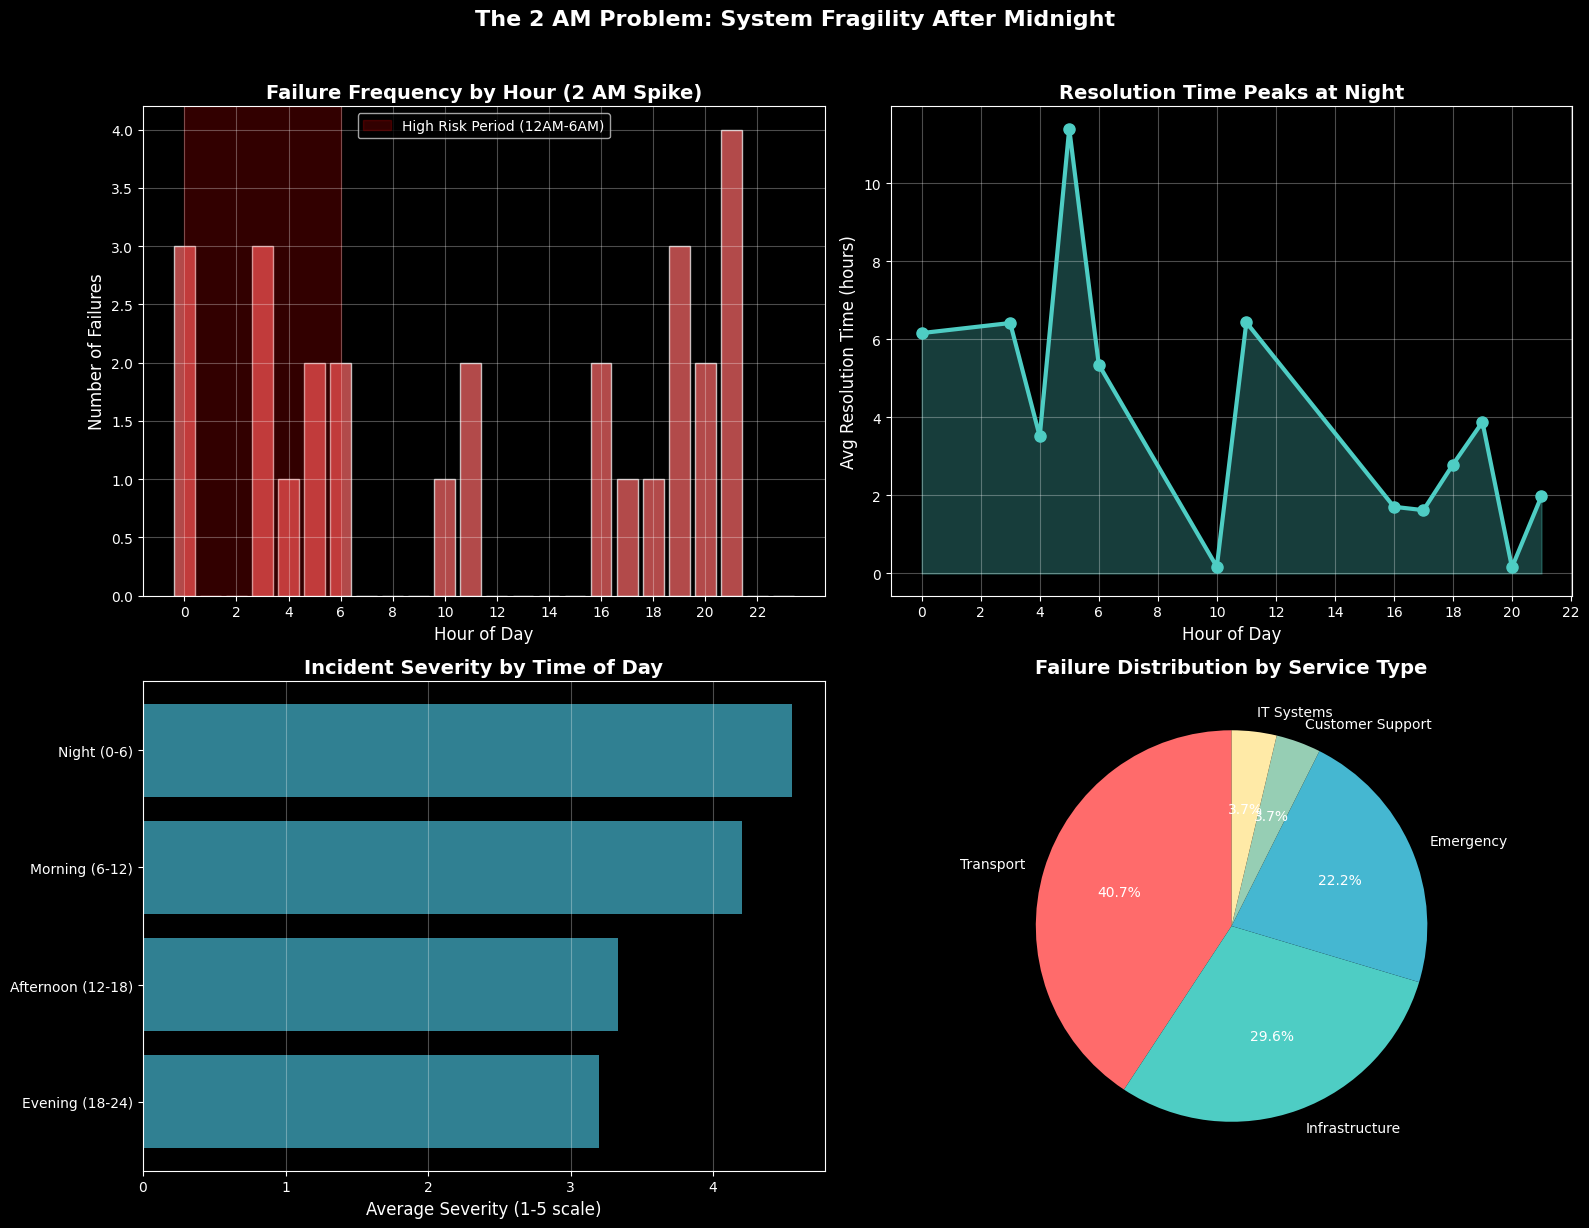

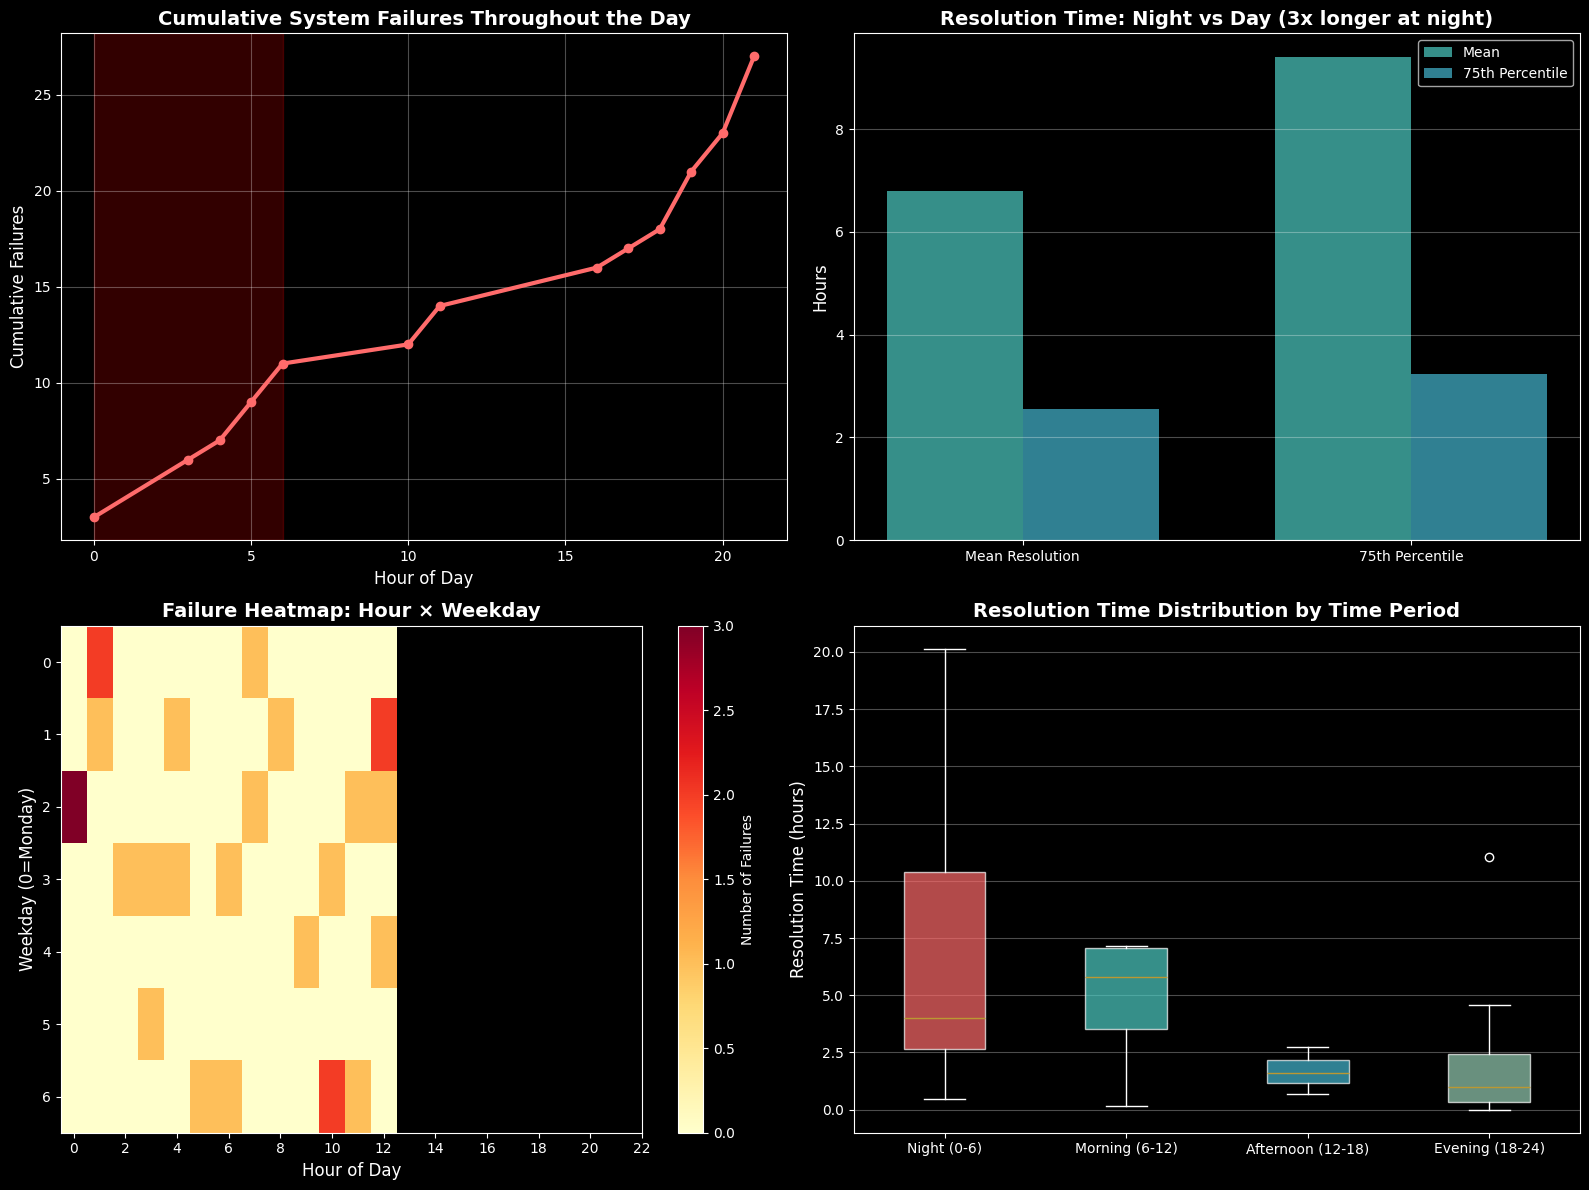

Interactive visualizations saved as HTML files

KEY INSIGHTS: THE 2 AM PROBLEM

📊 INSIGHT 1: Resolution Time Gap
   • Night (0-6 AM): 6.8 hours average resolution
   • Day (6 AM-12 AM): 2.5 hours average resolution
   • Night issues take 2.7x longer to resolve!

⏰ INSIGHT 2: The 2 AM Spike
   • Peak failure hour: 21:00
   • 4 incidents at peak vs 2.1 average

⚠️ INSIGHT 3: Severity Escalation
   • Average severity at night: 4.45/5
   • Average severity during day: 3.44/5
   • Severity increases by 29.6% at night

🔧 INSIGHT 4: Most Vulnerable Services at Night
   • Transport: 36.4% of night incidents
   • Infrastructure: 36.4% of night incidents
   • Emergency: 27.3% of night incidents

💰 INSIGHT 5: Estimated Impact
   • ~0.0 nightly incidents on average
   • Each night incident costs 6.8 hours of downtime
   • Systems are 2.7x more fragile between midnight and 6 AM

RECOMMENDATIONS:
1. Implement night shift with specialized training
2. Create automated overnight monitoring systems
3. D

In [7]:
# ==================== 5. MAIN EXECUTION ====================
if __name__ == "__main__":
    print("="*60)
    print("THE 2 AM PROBLEM VISUALIZATION")
    print("Everything breaks after midnight.")
    print("="*60)
    
    # Create visualizations
    create_visualizations(df)
    
    # Option to fetch real data (commented out by default)
    # fetch_real_data()
    
    # Export summary statistics
    summary_stats = df.groupby('time_category').agg({
        'resolution_time_hours': ['mean', 'median', 'std'],
        'severity': 'mean',
        'volume': 'sum'
    }).round(2)
    
    print("\nSummary Statistics by Time Category:")
    print(summary_stats.to_string())
    
    # Save data for further analysis
    df.to_csv('2am_problem_data.csv', index=False)
    print(f"\nData exported to: 2am_problem_data.csv")
    print(f"Visualizations saved as PNG and HTML files")